In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

#import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
Using TensorFlow backend.


# Text Classification Using SVM
### DATA MINING

# Loading the Dataset

In [0]:
#Loading the data set - training data.
from sklearn.datasets import fetch_20newsgroups
train = fetch_20newsgroups(subset='train', shuffle=True)
test=fetch_20newsgroups(subset='test', shuffle=True)
all=fetch_20newsgroups(subset='all', shuffle=True)

# Visualize Dataset

In [3]:
print("\n".join(train.data[1].split("\n")))
print(train.target[1])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>

4


In [4]:
print(len(train.data))
print(len(test.data))

11314
7532


In [5]:
print("\n".join(test.data[0].split("\n")))

From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)
Subject: Need info on 88-89 Bonneville
Organization: University at Buffalo
Lines: 10
News-Software: VAX/VMS VNEWS 1.41
Nntp-Posting-Host: ubvmsd.cc.buffalo.edu


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler



In [6]:
test.target[0:5]

array([ 7,  5,  0, 17, 19])

In [7]:
train.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [8]:
# You can check the target names (categories) and some data files by following commands.
train.target_names #prints all the categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [9]:
print(train.data[0].split())

['From:', 'lerxst@wam.umd.edu', "(where's", 'my', 'thing)', 'Subject:', 'WHAT', 'car', 'is', 'this!?', 'Nntp-Posting-Host:', 'rac3.wam.umd.edu', 'Organization:', 'University', 'of', 'Maryland,', 'College', 'Park', 'Lines:', '15', 'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day.', 'It', 'was', 'a', '2-door', 'sports', 'car,', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s.', 'It', 'was', 'called', 'a', 'Bricklin.', 'The', 'doors', 'were', 'really', 'small.', 'In', 'addition,', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body.', 'This', 'is', 'all', 'I', 'know.', 'If', 'anyone', 'can', 'tellme', 'a', 'model', 'name,', 'engine', 'specs,', 'years', 'of', 'production,', 'where', 'this', 'car', 'is', 'made,', 'history,', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car,', 'please', 'e-mail.', 'Thanks,', '-', 'IL', 

In [0]:
import re
import nltk
from nltk.corpus import stopwords

In [0]:
def clean_news(raw_news):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_news) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(" ".join( meaningful_words ))

In [12]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
train_cleaned=[]
test_cleaned=[]
for i in range(len(train.data)):
  temp=clean_news(train.data[i])
  train_cleaned.append(temp)

for i in range(len(test.data)):
  temp=clean_news(test.data[i])
  test_cleaned.append(temp)  
  
  
print(len(train_cleaned),len(test_cleaned))  

11314 7532


In [0]:
total_news_cleaned=train_cleaned+test_cleaned

In [15]:
total_news_cleaned[0]

'lerxst wam umd edu thing subject car nntp posting host rac wam umd edu organization university maryland college park lines wondering anyone could enlighten car saw day door sports car looked late early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please e mail thanks il brought neighborhood lerxst'

In [16]:
train_cleaned[0]

'lerxst wam umd edu thing subject car nntp posting host rac wam umd edu organization university maryland college park lines wondering anyone could enlighten car saw day door sports car looked late early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please e mail thanks il brought neighborhood lerxst'

# TFIDF + Naive Bayes Without Data Cleaning

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = fetch_20newsgroups(subset='train')
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(11314, 130107)

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
newsgroups_test = fetch_20newsgroups(subset='test')
vectors_test = vectorizer.transform(newsgroups_test.data)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(pred, test.target),'\n')
print(classification_report(pred,test.target))

accuracy 0.8352363250132767 

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       302
           1       0.75      0.69      0.72       420
           2       0.63      0.74      0.68       334
           3       0.75      0.65      0.69       453
           4       0.84      0.83      0.83       387
           5       0.78      0.84      0.81       364
           6       0.78      0.82      0.80       371
           7       0.90      0.89      0.90       401
           8       0.96      0.93      0.95       410
           9       0.94      0.95      0.95       392
          10       0.97      0.95      0.96       408
          11       0.93      0.89      0.91       418
          12       0.77      0.79      0.78       380
          13       0.84      0.89      0.86       375
          14       0.91      0.87      0.89       414
          15       0.95      0.82      0.88       460
          16       0.91      0.76      0.83       4

# TF-IDF + Naive Bayes after Data Cleaning

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = train_cleaned
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train)
vectors.shape

(11314, 88868)

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
newsgroups_test = test_cleaned
vectors_test = vectorizer.transform(newsgroups_test)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, train.target)
pred = clf.predict(vectors_test)
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(pred, test.target))
print(classification_report(pred,test.target))

accuracy 0.8315188528943176
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       302
           1       0.73      0.68      0.70       417
           2       0.65      0.71      0.68       362
           3       0.73      0.64      0.68       442
           4       0.83      0.81      0.82       396
           5       0.76      0.83      0.79       362
           6       0.78      0.79      0.79       384
           7       0.89      0.90      0.90       392
           8       0.95      0.92      0.94       414
           9       0.94      0.95      0.94       393
          10       0.97      0.96      0.96       405
          11       0.93      0.89      0.91       415
          12       0.75      0.78      0.76       377
          13       0.84      0.90      0.87       366
          14       0.91      0.88      0.90       407
          15       0.95      0.85      0.90       446
          16       0.91      0.77      0.83       431

# TFIDF + Decision Tree before Data Cleaning

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = fetch_20newsgroups(subset='train')
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(11314, 130107)

In [28]:
from sklearn.tree import DecisionTreeClassifier 
newsgroups_test = fetch_20newsgroups(subset='test')
#newsgroups_test = test_cleaned
vectors_test = vectorizer.transform(newsgroups_test.data)
clf=DecisionTreeClassifier(max_depth = 500).fit(vectors, train.target)
pred= clf.predict(vectors_test) 
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(pred, test.target))
print(classification_report(pred,test.target))


accuracy 0.5509824747742963
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       314
           1       0.44      0.40      0.42       426
           2       0.57      0.52      0.54       425
           3       0.40      0.44      0.42       354
           4       0.55      0.49      0.52       432
           5       0.47      0.49      0.48       379
           6       0.72      0.66      0.69       424
           7       0.57      0.64      0.60       356
           8       0.75      0.71      0.73       422
           9       0.54      0.55      0.55       391
          10       0.67      0.69      0.68       388
          11       0.70      0.74      0.72       376
          12       0.32      0.33      0.33       382
          13       0.44      0.50      0.47       351
          14       0.62      0.62      0.62       392
          15       0.72      0.69      0.71       419
          16       0.62      0.50      0.55       447

# TFIDF + Decicion Tree after Data Cleaning

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = train_cleaned
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train)
vectors.shape
from sklearn.tree import DecisionTreeClassifier 
newsgroups_test = test_cleaned
vectors_test = vectorizer.transform(newsgroups_test)
clf=DecisionTreeClassifier(max_depth = 500).fit(vectors, train.target)
pred= clf.predict(vectors_test) 
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(pred, test.target))
print(classification_report(pred,test.target))



accuracy 0.5751460435475305
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       315
           1       0.48      0.43      0.45       433
           2       0.56      0.56      0.56       394
           3       0.45      0.41      0.43       424
           4       0.54      0.49      0.51       421
           5       0.55      0.57      0.56       383
           6       0.66      0.68      0.67       380
           7       0.60      0.55      0.57       431
           8       0.79      0.76      0.78       414
           9       0.61      0.62      0.61       394
          10       0.74      0.73      0.74       402
          11       0.69      0.73      0.71       376
          12       0.37      0.39      0.38       370
          13       0.51      0.55      0.53       363
          14       0.63      0.71      0.67       351
          15       0.73      0.74      0.74       391
          16       0.67      0.53      0.59       456

# TF-IDF + SVM before data cleaning

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = fetch_20newsgroups(subset='train')
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(11314, 130107)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(train.data, train.target)
predicted_svm = text_clf_svm.predict(test.data)
np.mean(predicted_svm == test.target)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.8238183749336165

# TF-IDF + SVM after data cleaning

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = train_cleaned
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train)
vectors.shape

(11314, 88868)

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(train_cleaned, train.target)
predicted_svm = text_clf_svm.predict(test_cleaned)
np.mean(predicted_svm == test.target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.82129580456718

# Now Using Word2Vec

In [0]:
def clean_news_w2v(raw_news):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_news) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(meaningful_words )

In [0]:
from gensim.models import Word2Vec
from matplotlib import pyplot as plt

In [0]:
total_cleaned=[]
for i in range(len(total_news_cleaned)):
  total_cleaned.append(clean_news_w2v(total_news_cleaned[i]))
  

In [20]:
total_cleaned[0]

['lerxst',
 'wam',
 'umd',
 'edu',
 'thing',
 'subject',
 'car',
 'nntp',
 'posting',
 'host',
 'rac',
 'wam',
 'umd',
 'edu',
 'organization',
 'university',
 'maryland',
 'college',
 'park',
 'lines',
 'wondering',
 'anyone',
 'could',
 'enlighten',
 'car',
 'saw',
 'day',
 'door',
 'sports',
 'car',
 'looked',
 'late',
 'early',
 'called',
 'bricklin',
 'doors',
 'really',
 'small',
 'addition',
 'front',
 'bumper',
 'separate',
 'rest',
 'body',
 'know',
 'anyone',
 'tellme',
 'model',
 'name',
 'engine',
 'specs',
 'years',
 'production',
 'car',
 'made',
 'history',
 'whatever',
 'info',
 'funky',
 'looking',
 'car',
 'please',
 'e',
 'mail',
 'thanks',
 'il',
 'brought',
 'neighborhood',
 'lerxst']

In [21]:
len(total_cleaned)

18846

In [0]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [22]:

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.0687989068945343
Accuracy: 0.7068234046314301


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


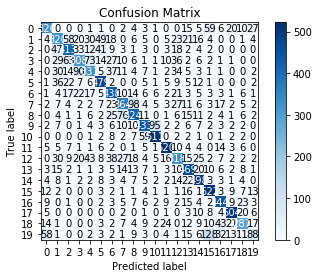

In [0]:
# Logistic Classifier Used

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarni

Log loss: 1.311216962011028
Accuracy: 0.6693477108007778


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


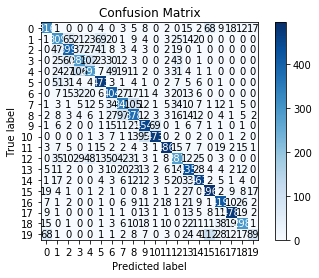

In [0]:
evaluate_features(mean_embedded, train.target,
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

# My way NOW for W2V

# Making X_train, X_test, Y_train, Y_test

In [0]:
all=fetch_20newsgroups(subset='all', shuffle=True)

In [0]:
x_train,x_test,y_train,y_test=train_test_split(total_cleaned,all.target,test_size=0.3,random_state=42)

In [0]:
x_total=x_train+x_test

In [29]:
len(x_train)

13192

In [30]:
len(x_test)

5654

In [31]:
#creating word2vec model
model= Word2Vec(x_total,size=100,window=5,sg=1,min_count=1,alpha=0.025)
#The raw vectors array of words in a Word2Vec is available in model.wv.syn0
#The list of words in the index-order of that array is in model.wv.index2word.
w2v = dict(zip(model.wv.index2word, model.wv.syn0))#train model
#w2v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [32]:
#converting to tfidf matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x: x)
matrix = vectorizer.fit_transform([x for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
#print(tfidf)
print('vocab size :', len(tfidf))

vocab size : 98212


In [0]:
#given a list of tweet tokens, creates an averaged tweet vector.
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [34]:
from sklearn.preprocessing import scale
from tqdm import tqdm#for progress bar while looping
train_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)#scale for mean=0 and std dev=1 

test_vecs_w2v = np.concatenate([buildWordVector(z, 100) for z in tqdm(map(lambda x: x, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)#scale for mean=0 and std dev=1

13192it [00:12, 1092.98it/s]
5654it [00:05, 1076.26it/s]


In [47]:
train_vecs_w2v.shape

(13192, 100)

In [48]:
test_vecs_w2v.shape

(5654, 100)

In [0]:
#classfication using svm
svc=SVC(kernel="rbf", C=0.025, probability=True)
svc.fit(train_vecs_w2v,y_train)
y_pred=svc.predict(test_vecs_w2v)
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

# Using FAST TEXT

In [0]:
from gensim.models import FastText
model1=FastText(x_train,size=100,window=5,sg=1,min_count=1,alpha=0.025)

In [0]:
ft = dict(zip(model1.wv.index2word, model1.wv.syn0))#train model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
def WordVectorfasttext(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += ft[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [0]:
train_vecs_ft = np.concatenate([WordVectorfasttext(z, 100) for z in tqdm(map(lambda x: x, x_train))])
train_vecs_ft = scale(train_vecs_ft)#scale for mean=0 and std dev=1 

test_vecs_ft = np.concatenate([WordVectorfasttext(z, 100) for z in tqdm(map(lambda x: x, x_test))])
test_vecs_ft = scale(test_vecs_ft)#scale for mean=0 and std dev=1


0it [00:00, ?it/s]
91it [00:00, 902.30it/s]
183it [00:00, 907.07it/s]
326it [00:00, 1018.41it/s]
414it [00:00, 970.80it/s] 
533it [00:00, 1025.13it/s]
660it [00:00, 1087.22it/s]
781it [00:00, 1120.46it/s]
903it [00:00, 1146.84it/s]
1015it [00:00, 1117.25it/s]
1125it [00:01, 907.35it/s] 
1221it [00:01, 875.25it/s]
1344it [00:01, 957.04it/s]
1445it [00:01, 859.89it/s]
1582it [00:01, 968.01it/s]
1694it [00:01, 1008.39it/s]
1834it [00:01, 1097.08it/s]
1951it [00:01, 1079.77it/s]
2064it [00:01, 1074.23it/s]
2180it [00:02, 1093.62it/s]
2292it [00:02, 958.29it/s] 
2393it [00:02, 800.17it/s]
2517it [00:02, 894.94it/s]
2616it [00:02, 907.28it/s]
2735it [00:02, 974.97it/s]
2839it [00:02, 934.97it/s]
2937it [00:02, 937.02it/s]
3036it [00:03, 950.10it/s]
3159it [00:03, 1017.86it/s]
3264it [00:03, 901.84it/s] 
3359it [00:03, 909.09it/s]
3454it [00:03, 773.99it/s]
3541it [00:03, 799.39it/s]
3626it [00:03, 739.75it/s]
3732it [00:03, 813.03it/s]
3857it [00:03, 907.42it/s]
3965it [00:04, 949.39it/s]
4

In [0]:
#classfication using svm
svc2=SVC(kernel="linear", C=0.025, probability=True)
svc2.fit(train_vecs_ft,y_train)
y_pred2=svc2.predict(test_vecs_ft)
print(y_pred2)

[ 6  5  5 ...  5 17  3]


In [0]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred2, y_test))
print(classification_report(y_pred2, y_test))

accuracy 0.05217545100813583
              precision    recall  f1-score   support

           0       0.02      0.07      0.03        60
           1       0.06      0.05      0.05       376
           2       0.06      0.04      0.05       388
           3       0.07      0.06      0.06       352
           4       0.04      0.06      0.05       235
           5       0.06      0.05      0.05       438
           6       0.07      0.06      0.06       332
           7       0.05      0.04      0.04       336
           8       0.09      0.05      0.06       552
           9       0.07      0.05      0.06       446
          10       0.04      0.05      0.04       234
          11       0.06      0.05      0.06       321
          12       0.04      0.05      0.05       239
          13       0.04      0.05      0.04       240
          14       0.04      0.06      0.04       196
          15       0.10      0.07      0.08       418
          16       0.02      0.04      0.03       12

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Using DOC2VEC

In [0]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [0]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(total_news_cleaned)]

In [0]:
tagged_data[0]

TaggedDocument(words=['lerxst', 'wam', 'umd', 'edu', 'thing', 'subject', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'e', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst'], tags=['0'])

In [0]:

from tqdm  import  tqdm
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [0]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=1, min_count=1, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(tagged_data)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 18846/18846 [00:00<00:00, 1297577.94it/s]


In [0]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(tagged_data)]), total_examples=len(tagged_data), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 18846/18846 [00:00<00:00, 2323442.97it/s]


CPU times: user 2min 46s, sys: 9.63 s, total: 2min 56s
Wall time: 1min 52s


In [0]:
def  get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in range(len(corpus)):
        prefix = str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [0]:
train_cleaned[0]

'lerxst wam umd edu thing subject car nntp posting host rac wam umd edu organization university maryland college park lines wondering anyone could enlighten car saw day door sports car looked late early called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please e mail thanks il brought neighborhood lerxst'

In [0]:
#Calculating Vectors
train_vecs_dbow = get_vectors(model_ug_dbow, train_cleaned, 100)
test_vecs_dbow = get_vectors(model_ug_dbow, test_cleaned, 100)

In [0]:
X_train=train_vecs_dbow

In [0]:
X_test=test_vecs_dbow

In [0]:
from sklearn import svm
import numpy as np
clf = svm.SVC(gamma='scale')
clf.fit(X_train, np.asarray(train.target))  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
pred=clf.predict(X_test)

In [0]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(pred, test.target))
print(classification_report(pred, test.target))

accuracy 0.04965480616038237
              precision    recall  f1-score   support

           0       0.07      0.07      0.07       313
           1       0.05      0.05      0.05       405
           2       0.05      0.05      0.05       415
           3       0.06      0.06      0.06       397
           4       0.04      0.04      0.04       393
           5       0.05      0.05      0.05       404
           6       0.06      0.06      0.06       398
           7       0.05      0.05      0.05       383
           8       0.05      0.05      0.05       405
           9       0.07      0.06      0.06       407
          10       0.05      0.05      0.05       387
          11       0.05      0.05      0.05       390
          12       0.04      0.04      0.04       402
          13       0.06      0.05      0.06       401
          14       0.05      0.05      0.05       372
          15       0.05      0.05      0.05       409
          16       0.04      0.04      0.04       36

In [0]:
# https://github.com/hsd31196/Twitter-Sentiment-Analysis/blob/master/twitter_sentiment_analysis.ipynb harsh